In [25]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random
import time
from datetime import datetime
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from keras.datasets import mnist
from sklearn.metrics import mean_squared_error
from plot_keras_history import show_history, plot_history
print("No. of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

No. of GPUs available:  1


In [26]:
#Splitting the dataset.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
dataset = np.concatenate([x_train], axis=0)  #Preprocessing the dataset.
dataset = np.expand_dims(dataset, -1).astype("float32") / 255  #Increasing the dimension of the data to 3 layers & Normalizing the dataset from 0 to 1.
#dataset.reshape(-1, 28, 28, 1)
print(len(x_train))

60000


In [27]:
dataset = np.reshape(dataset, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.shuffle(buffer_size=1024).batch(64)


In [28]:
Noise_Dim = 50

generator = keras.models.Sequential([keras.layers.InputLayer(input_shape=(Noise_Dim,)), layers.Dense(7*7*256),
                                    layers.Reshape(target_shape=(7, 7, 256)),
                                    layers.Conv2DTranspose(128, 3, activation="LeakyReLU", strides=2, padding="same" , input_shape=(28,28,1)),
                                    layers.Conv2DTranspose(64, 3, activation="LeakyReLU", strides=2, padding="same"),
                                    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")], name="Generator")
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             639744    
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 28, 28, 1)        577       
 ranspose)                                                       
                                                         

In [29]:
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(28,28,1)), 
    layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"), layers.Dropout(0.2), layers.Dense(1, activation="sigmoid")
], name="Discriminator")

discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 256)       2560      
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                401472    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-t

In [30]:
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

loss = keras.losses.BinaryCrossentropy(from_logits=True)

AccG = tf.keras.metrics.BinaryAccuracy()
AccD = tf.keras.metrics.BinaryAccuracy()

In [31]:
@tf.function
def trainDstep(data):
    batchsize = tf.shape(data)[0]
    #print(data)
    #print(tf.shape(data)[0])
    noise = tf.random.normal(shape=(batchsize, Noise_Dim)) #Noise vector as generator input
    #_ , y_true = generate_real_samples(x_train, len(x_train))
    y_true = tf.concat([tf.ones(batchsize, 1), tf.zeros(batchsize, 1)], axis=0)
    #y_true.reshape((128, 64))
    #print(y_true)
    with tf.GradientTape() as tape:
        fake = generator(noise) #Generate samples
        #real = data.reshape(128, 64)
        #print(noise)
        #print(fake.shape)
        x = tf.concat([data, fake], axis=0) #Combining real and fake data.
        #y_true = discriminator(y_true)
        #print(y_true.shape)
        y_pred = discriminator(x) #Discreminator detects them.
        #print(y_pred.shape)
        #print(tf.shape(y_true))
        #print(tf.shape(y_pred))
        Dloss = loss(y_true, y_pred)
        
    grad = tape.gradient(Dloss, discriminator.trainable_weights) #Backpropagation for training.
    optimizerD.apply_gradients(zip(grad, discriminator.trainable_weights))
    AccD.update_state(y_true, y_pred)
    
    return{
        "Discriminator Loss": Dloss,
        "Discriminator Accuracy": AccD.result()
    }
        

In [32]:
@tf.function
def trainGstep(data):
    batchsize = tf.shape(data)[0]
    noise = tf.random.normal(shape=(batchsize, Noise_Dim)) #Noise vector as generator input
    
    y_true = tf.ones(batchsize, 1)
    #y_true = tf.reshape(y_true, (128, 64))
    with tf.GradientTape() as tape:
        
        y_pred = discriminator(generator(noise)) #Discreminator detects them.
        
        Gloss = loss(y_true, y_pred)
        
    grad = tape.gradient(Gloss, generator.trainable_weights) #Backpropagation for training.
    optimizerG.apply_gradients(zip(grad, generator.trainable_weights))
    AccG.update_state(y_true, y_pred)
    
    return{
        "Generator Loss": Gloss,
        "Generator Accuracy": AccG.result()
    }

In [33]:
from matplotlib import pyplot as plt

def plotimg(model):
    imgs = model(np.random.normal(size=(81, Noise_Dim)))
    
    plt.figure(figsize=(9, 9))
    
    for i, image in enumerate(imgs):
        plt.subplot(9, 9, i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis("off")
    plt.show()

GAccSum- tf.Tensor(19.764505, shape=(), dtype=float32)
Episodes: 1 Generator Loss: 0.6755 Discriminator Loss: 0.5198 Generator Accuracy: 2.11 Discriminator Accuracy: 98.18
GAccSum- tf.Tensor(2.0786417, shape=(), dtype=float32)
Episodes: 2 Generator Loss: 0.6931 Discriminator Loss: 0.5032 Generator Accuracy: 0.22 Discriminator Accuracy: 99.80
GAccSum- tf.Tensor(1.216129, shape=(), dtype=float32)
Episodes: 3 Generator Loss: 0.6931 Discriminator Loss: 0.5032 Generator Accuracy: 0.13 Discriminator Accuracy: 99.88
GAccSum- tf.Tensor(0.8629129, shape=(), dtype=float32)
Episodes: 4 Generator Loss: 0.6931 Discriminator Loss: 0.5032 Generator Accuracy: 0.09 Discriminator Accuracy: 99.92
GAccSum- tf.Tensor(0.6693503, shape=(), dtype=float32)
Episodes: 5 Generator Loss: 0.6931 Discriminator Loss: 0.5032 Generator Accuracy: 0.07 Discriminator Accuracy: 99.93


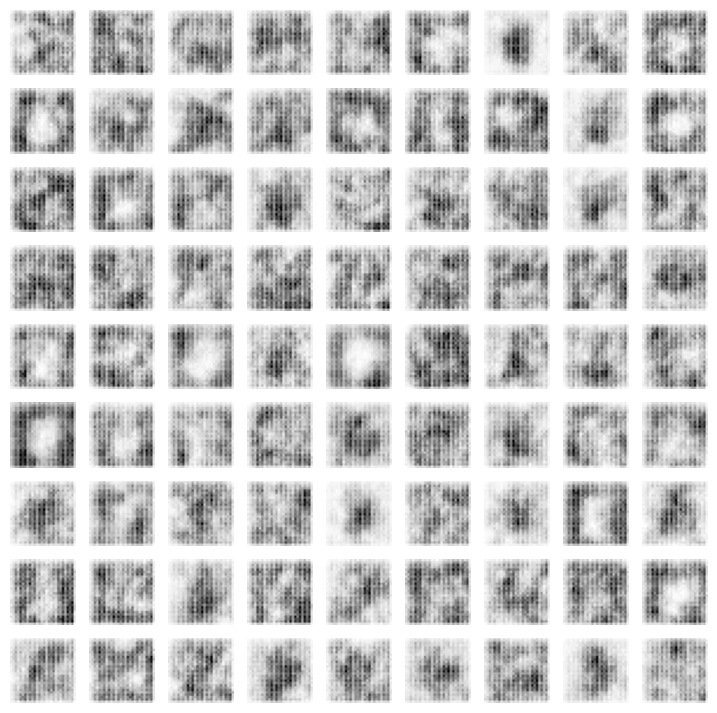

GAccSum- tf.Tensor(0.5469112, shape=(), dtype=float32)
Episodes: 6 Generator Loss: 0.6931 Discriminator Loss: 0.5032 Generator Accuracy: 0.06 Discriminator Accuracy: 99.95
GAccSum- tf.Tensor(0.46241403, shape=(), dtype=float32)
Episodes: 7 Generator Loss: 0.6931 Discriminator Loss: 0.5032 Generator Accuracy: 0.05 Discriminator Accuracy: 99.96
GAccSum- tf.Tensor(0.40619972, shape=(), dtype=float32)
Episodes: 8 Generator Loss: 0.6924 Discriminator Loss: 0.5039 Generator Accuracy: 0.04 Discriminator Accuracy: 99.96
GAccSum- tf.Tensor(0.48048007, shape=(), dtype=float32)
Episodes: 9 Generator Loss: 0.6891 Discriminator Loss: 0.5082 Generator Accuracy: 0.05 Discriminator Accuracy: 99.95
GAccSum- tf.Tensor(3.532139, shape=(), dtype=float32)
Episodes: 10 Generator Loss: 0.6550 Discriminator Loss: 0.5676 Generator Accuracy: 0.38 Discriminator Accuracy: 99.34


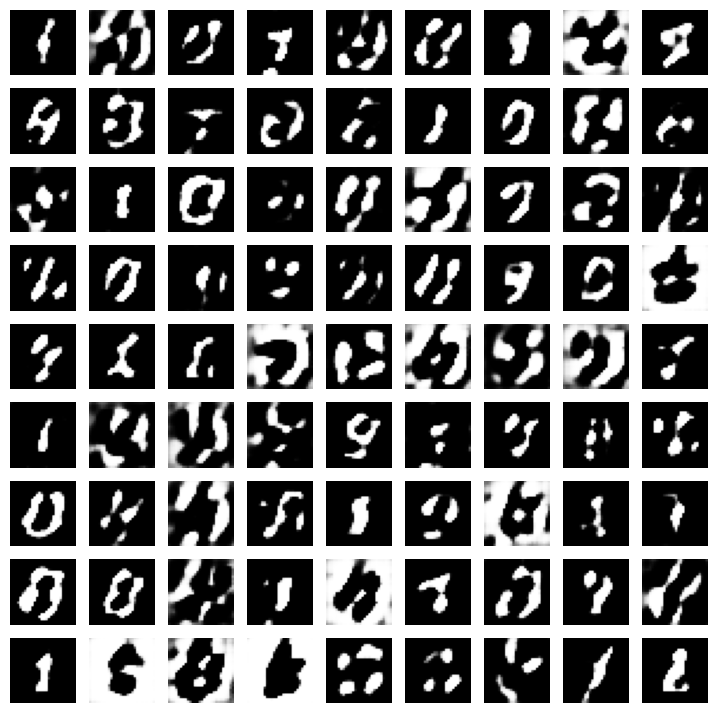

GAccSum- tf.Tensor(10.095415, shape=(), dtype=float32)
Episodes: 11 Generator Loss: 0.6453 Discriminator Loss: 0.6143 Generator Accuracy: 1.08 Discriminator Accuracy: 97.43
GAccSum- tf.Tensor(16.30052, shape=(), dtype=float32)
Episodes: 12 Generator Loss: 0.6391 Discriminator Loss: 0.6285 Generator Accuracy: 1.74 Discriminator Accuracy: 95.19
GAccSum- tf.Tensor(21.887392, shape=(), dtype=float32)
Episodes: 13 Generator Loss: 0.6302 Discriminator Loss: 0.6140 Generator Accuracy: 2.33 Discriminator Accuracy: 93.38
GAccSum- tf.Tensor(26.125843, shape=(), dtype=float32)
Episodes: 14 Generator Loss: 0.6355 Discriminator Loss: 0.5845 Generator Accuracy: 2.79 Discriminator Accuracy: 92.49
GAccSum- tf.Tensor(27.369217, shape=(), dtype=float32)
Episodes: 15 Generator Loss: 0.6449 Discriminator Loss: 0.5688 Generator Accuracy: 2.92 Discriminator Accuracy: 92.22


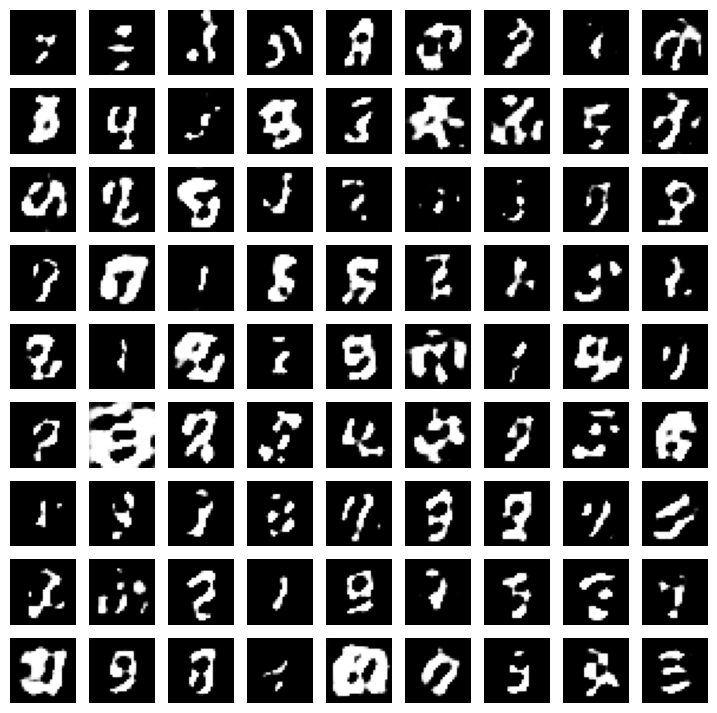

GAccSum- tf.Tensor(27.516922, shape=(), dtype=float32)
Episodes: 16 Generator Loss: 0.6468 Discriminator Loss: 0.5667 Generator Accuracy: 2.93 Discriminator Accuracy: 92.13
GAccSum- tf.Tensor(28.04828, shape=(), dtype=float32)
Episodes: 17 Generator Loss: 0.6356 Discriminator Loss: 0.5914 Generator Accuracy: 2.99 Discriminator Accuracy: 91.87
GAccSum- tf.Tensor(29.160837, shape=(), dtype=float32)
Episodes: 18 Generator Loss: 0.6364 Discriminator Loss: 0.5937 Generator Accuracy: 3.11 Discriminator Accuracy: 91.31
GAccSum- tf.Tensor(29.707462, shape=(), dtype=float32)
Episodes: 19 Generator Loss: 0.6431 Discriminator Loss: 0.5778 Generator Accuracy: 3.17 Discriminator Accuracy: 90.98
GAccSum- tf.Tensor(29.928741, shape=(), dtype=float32)
Episodes: 20 Generator Loss: 0.6478 Discriminator Loss: 0.5681 Generator Accuracy: 3.19 Discriminator Accuracy: 90.85


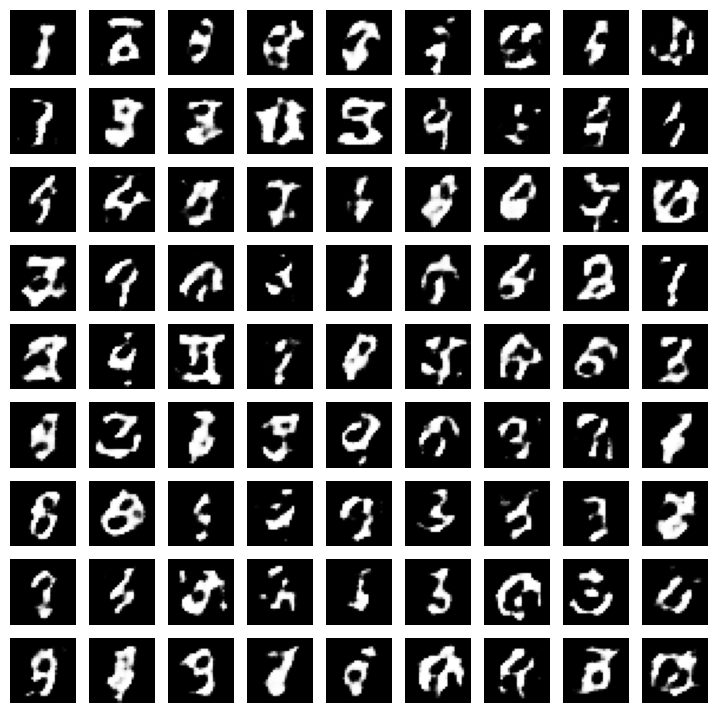

GAccSum- tf.Tensor(30.023186, shape=(), dtype=float32)
Episodes: 21 Generator Loss: 0.6498 Discriminator Loss: 0.5676 Generator Accuracy: 3.20 Discriminator Accuracy: 90.77
GAccSum- tf.Tensor(29.987902, shape=(), dtype=float32)
Episodes: 22 Generator Loss: 0.6534 Discriminator Loss: 0.5636 Generator Accuracy: 3.20 Discriminator Accuracy: 90.71
GAccSum- tf.Tensor(29.801111, shape=(), dtype=float32)
Episodes: 23 Generator Loss: 0.6556 Discriminator Loss: 0.5606 Generator Accuracy: 3.18 Discriminator Accuracy: 90.66
GAccSum- tf.Tensor(29.526167, shape=(), dtype=float32)
Episodes: 24 Generator Loss: 0.6575 Discriminator Loss: 0.5589 Generator Accuracy: 3.15 Discriminator Accuracy: 90.64
GAccSum- tf.Tensor(29.256172, shape=(), dtype=float32)
Episodes: 25 Generator Loss: 0.6592 Discriminator Loss: 0.5575 Generator Accuracy: 3.12 Discriminator Accuracy: 90.62


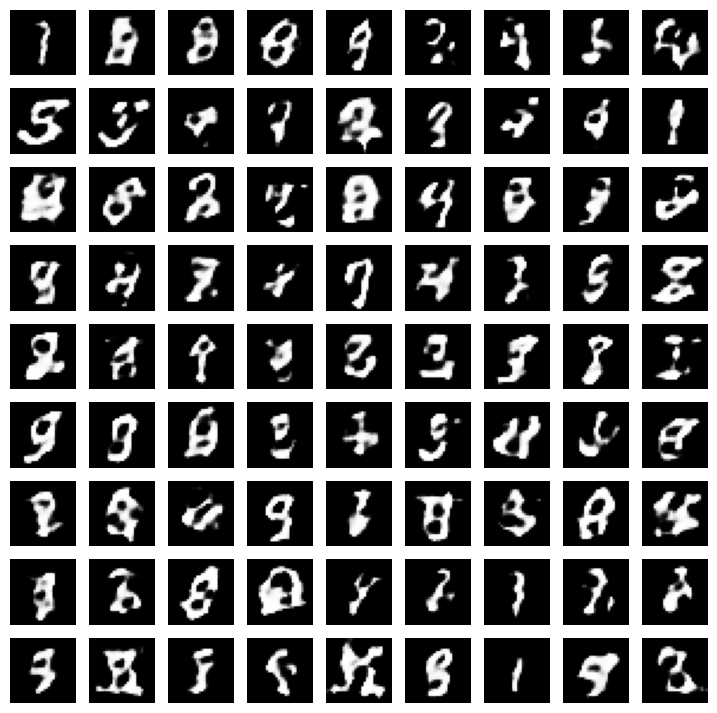

GAccSum- tf.Tensor(29.00963, shape=(), dtype=float32)
Episodes: 26 Generator Loss: 0.6590 Discriminator Loss: 0.5562 Generator Accuracy: 3.09 Discriminator Accuracy: 90.61
GAccSum- tf.Tensor(28.877419, shape=(), dtype=float32)
Episodes: 27 Generator Loss: 0.6590 Discriminator Loss: 0.5563 Generator Accuracy: 3.08 Discriminator Accuracy: 90.61
GAccSum- tf.Tensor(28.791014, shape=(), dtype=float32)
Episodes: 28 Generator Loss: 0.6586 Discriminator Loss: 0.5566 Generator Accuracy: 3.07 Discriminator Accuracy: 90.61
GAccSum- tf.Tensor(28.784792, shape=(), dtype=float32)
Episodes: 29 Generator Loss: 0.6582 Discriminator Loss: 0.5579 Generator Accuracy: 3.07 Discriminator Accuracy: 90.59
GAccSum- tf.Tensor(28.87416, shape=(), dtype=float32)
Episodes: 30 Generator Loss: 0.6579 Discriminator Loss: 0.5583 Generator Accuracy: 3.08 Discriminator Accuracy: 90.57


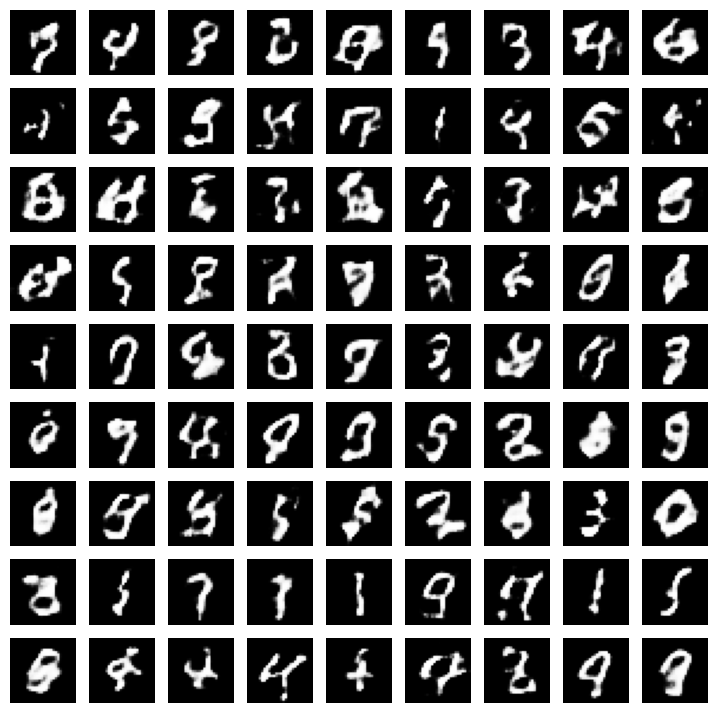

In [35]:
for epoches in range(1,31):
    DLSum, GLSum, DAccSum, GAccSum, count = 0, 0, 0, 0, 0
    for batch in dataset:
        #print(batch.shape)
        DLoss = trainDstep(batch)
        DLSum += DLoss['Discriminator Loss']
        DAccSum += DLoss['Discriminator Accuracy']
        
        GLoss = trainGstep(batch)
        GLSum += GLoss['Generator Loss']
        GAccSum += GLoss['Generator Accuracy']
        
        count+=1
    print("GAccSum-",GAccSum)
    print("Episodes: {} Generator Loss: {:0.4f} Discriminator Loss: {:0.4f} Generator Accuracy: {:0.2f} Discriminator Accuracy: {:0.2f}".format(
            epoches, GLSum/count, DLSum/count, (GAccSum/count)*100, (DAccSum/count)*100))
    
    if epoches % 5 == 0:
        plotimg(generator)

In [36]:
images = generator(np.random.normal(size=(81, Noise_Dim)))

plotimg(images)

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object is not callable